# Aim:
We are given unlabelled dataset of wood texture. We need to train a neural network to classify and detect anomlies (wood, knots, etc.)

# Background:

My first intuition looking at the dataset is that it is too small. I really need to design some way to generate synthetic data from the given dataset. Secondly, I need to figure out what category of problem it is; i.e. object localization/detection, segmentation, instance segmentation, or classification. And thirdly, how should I tackle this problem either in supervised, semi-supervised, or unsupervised settings.

Let's first decide how we are going tackle this problem, as it would be the deciding factor whether we would require to label our data or not.


### Setting of ML Problem
We have 3 choices: Supervised, Semi- Supervised, and Unsupervised.

1) Supervised Learning: Solving this challenge in supervised learning would require us to label the dataset into some acceptable format. Later we can train a neural network to perform classification and detection. The simplest approach would be to train a network to perform classification and segmentation using a single network like MaskRCNN or Yolo. Alternatively, we can train two separate network to perform classification and segmentation individually.<br/>
2)  Semi-Supervised Learning: In semi-supervised learning setting we would still require to little labelled data.  Later we can train an Auto Encoder based student teacher network to perform segmentation and classification.<br/>
3) Unsupervised Learning: In unsupervised learning we won't be required to label our dataset. We can train an AutoEncoder on without anomaly images(perfect texture) on image reconstruction task. And later use it to reconstruct anomalous images. Pixel difference between the output and input would be our segmented anomalies .Example : https://benjoe.medium.com/anomaly-detection-using-pytorch-autoencoder-and-mnist-31c5c2186329 <br/>


Our setting:<br/>
Out of these 3 choices. I decide to go with Supervised Learning approach. Using semi-supervised approach I would require relatively large amount of dataset and data augmentation won't help. And using unsupervised approach I would be able to detect and segment the anomalies but however won't be able to classify its type on such little data. Moreover, in semi-supervised as well as unsupervised approach segmented images won't be pixel perfect which is critical in anomaly detection task.

### Determining type of Neural Network and Problem.

Since our task is to classify and segment the anomalies with its type, one obvious and intuitive choice would be to use object detection and segmentation network like MaskRCNN or Yolo. However, due to lack of sufficient dataset the proposed bounding region by Feature Pyramid Network(FPN) might not be correct due to which we might obtain low model accuracy score. We can use image segmentation network like UNet to segment the anomalies in general. However, we won't be able to classify it in various classes.

Instead of considering it as vanilla segmentation task. I hypothesize to consider it as Instance Segmentation task. We have 3 categories of instances (anomalies) here: No anomaly/Perfect, Spot and Knots. So accordingly we can label our segmentation mask into those three categories and later train an image segmentation network to segment them.

For the choice of my Neural Network I am considering UNet architecture because of parameters simplicity and accuracy on segmentation task.

# Dataset

I used labelme[1] tool to segment the available images. I used green color to label spots and red to label knots. See "annotated_data"   folder

Overview of the given dataset looks like:

| Type of image |         |       |       |
|---------------|---------|-------|-------|
|               | Perfect | Spots | Knots |
| Perfect       | 2       | 0     | 0     |
| Spots         | 0       | 3     | 1     |
| Knots         | 0       | 1     | 1     |

As we can see from the above table that our dataset is imbalanced. Let's balance the no of perfect images by 1, images with spots and knots by 2 and images with only knots by 2. Thus taking our total image offline image set to 12. To create these augmented image I will be applying some random flipping and shifting only. Later I will use some more complex in-training data augmentation.

### Synthetic Data Generation: A Failed Experiment !!!

Once I finalized my strategy I set to write code to create a synthetic data generator. I had a very simple idea: Crop the anomalies and poisson blend them with the perfect texture image to create large synthetic data. I started by cropping the anomalies into various tight patches. Later I poisson blended[2] those image on the perfect texture images to create synthetic data. However, my hypothesis for this idea was completely wrong. Due to same color frequency in texture and anomaly images my generated, in my generated images the anomalies were invisible or lacking details. See the script and output in "experiment/" folder.

## Code

In [1]:
import glob
import pytorch_lightning as pl
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import random

from matplotlib import pyplot as plt
from PIL import Image
from pytorch_lightning.loggers import TensorBoardLogger
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision.transforms import Compose, ToTensor, Resize, GaussianBlur, ColorJitter, RandomHorizontalFlip, RandomVerticalFlip
import torchvision.transforms.functional as TF

torch.manual_seed(4716360)

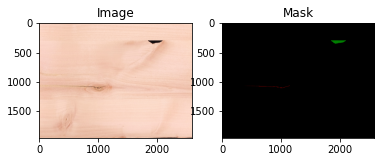

In [2]:
# Let's visualize our labelled dataset
image = Image.open("annotated_data/input/2021-04-07 21_43_40_exai_rpi_004_156.jpg")
mask = Image.open("annotated_data/segmentation_mask/2021-04-07 21_43_40_exai_rpi_004_156.png")
fig, axs = plt.subplots(1, 2)
axs[0].imshow(image)
axs[0].set_title('Image')
axs[1].imshow(mask)
axs[1].set_title('Mask')
plt.show()


## Defining Dataloader

In [3]:
# Create Dataset Class
class WoodDataset(Dataset):
    def __init__(self, datasetDir="./annotated_data"):
        datasetDir = os.path.join(datasetDir)
        input_image_dir = os.path.join(datasetDir, "input")
        self.mask_dir = os.path.join(datasetDir, "segmentation_mask")


        self.input_images = glob.glob(input_image_dir+"/*.jpg")
        self.segmentation_masks = glob.glob(self.mask_dir+"/*.png")

        self.transform_image = Compose([
            ToTensor(),
            Resize((224, 224)),
            # RandomVerticalFlip(p=0.5),
            # RandomHorizontalFlip(p=0.5),
            ColorJitter(),
            GaussianBlur(3),
        ])

        self.transform_mask = Compose([ToTensor(), Resize((224, 224))])


    def __len__(self):
        return  len(self.input_images)

    def __getitem__(self, index):
        image = Image.open(self.input_images[index])
        file_name = self.input_images[index].split("/")[-1]
        file_name = file_name.split(".")[0]
        mask = Image.open(os.path.join(self.mask_dir, file_name+".png")).convert("RGB")

        # Apply data augmentation during training
        image = self.transform_image(image)
        mask = self.transform_mask(mask)

        # Apply same flipping to image and target
        # Issue: https://github.com/pytorch/vision/issues/9
        hflip = random.random() > 0.5
        if hflip:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        vflip = random.random() > 0.5
        if vflip:
            image = TF.vflip(image)
            mask = TF.vflip(mask)
        return image, mask

class WoodDataModule(pl.LightningDataModule):
    def __init__(self, batch_size):
        super().__init__()
        self.batch_size = batch_size

        dataset = WoodDataset()
        self.train_data, self.val_data = random_split(dataset, [9,3])


    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.val_data, batch_size=self.batch_size)


torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
tensor([0.0000, 0.0205, 0.0615, 0.0717, 0.1434, 0.3073, 0.3074, 0.3586, 0.3790,
        0.5020])


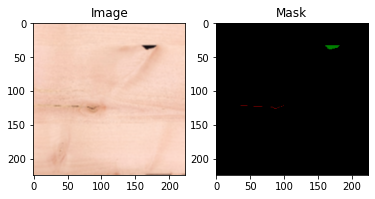

In [4]:
# Test the dataset class
test = WoodDataset()
img, msk = test.__getitem__(1)
print(img.shape)
print(msk.shape)
print(torch.unique(msk))
fig, axs = plt.subplots(1, 2)
axs[0].imshow(img.permute(1,2,0))
axs[0].set_title('Image')
axs[1].imshow(msk.permute(1,2,0))
axs[1].set_title('Mask')
plt.show()

## Defining model and training classes

In [5]:
class UNet(pl.LightningModule):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()

        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = True

        self.current_train_loss = 0.0


        def double_conv(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
            )

        def down(in_channels, out_channels):
            return nn.Sequential(
                nn.MaxPool2d(2),
                double_conv(in_channels, out_channels)
            )

        class up(nn.Module):
            def __init__(self, in_channels, out_channels, bilinear=True):
                super().__init__()

                if bilinear:
                    self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
                else:
                    self.up = nn.ConvTranpose2d(in_channels // 2, in_channels // 2,
                                                kernel_size=2, stride=2)

                self.conv = double_conv(in_channels, out_channels)

            def forward(self, x1, x2):
                x1 = self.up(x1)
                # [?, C, H, W]
                diffY = x2.size()[2] - x1.size()[2]
                diffX = x2.size()[3] - x1.size()[3]

                x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                                diffY // 2, diffY - diffY // 2])
                x = torch.cat([x2, x1], dim=1) ## why 1?
                return self.conv(x)

        self.inc = double_conv(self.n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.out = nn.Conv2d(64, self.n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        return self.out(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = F.binary_cross_entropy_with_logits(y_hat, y)
        self.log("train/loss", loss, on_step=False, on_epoch=True, logger=True)
        return loss

    def training_epoch_end(self, outputs):
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        tensorboard_logs = {'train_loss': avg_loss}
        print("Epoch : {}, train/loss: {}".format(self.current_epoch, avg_loss))

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = F.binary_cross_entropy_with_logits(y_hat, y)
        self.log("val/loss", loss, on_step=False, on_epoch=True, logger=True)
        return {'val_loss': loss}

    def validation_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        tensorboard_logs = {'val_loss': avg_loss}

        return {'avg_val_loss': avg_loss, 'log': tensorboard_logs}

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=5e-4, weight_decay=1e-8)


    def predict(self, image):
        output = self.forward(image)
        return output


In [6]:
# test class
hparams = {
    "n_channels": 3,
    "n_classes": 2
}
net = UNet(3, 3)
dummy_input = torch.randn(2,3,224,224)
out = net(dummy_input)
print(out.shape)

torch.Size([2, 3, 224, 224])


## Training

In [7]:
logger = TensorBoardLogger(save_dir="tensorboard_logs")
model = UNet(n_channels=3, n_classes=3)
dm = WoodDataModule(batch_size=4)
trainer = pl.Trainer(max_epochs=150, logger=logger)
trainer.fit(model, dm)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/opt/anaconda3/envs/extend-ai/lib/python3.6/site-packages/pytorch_lightning/trainer/trainer.py:1585: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  "GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`."

  | Name  | Type       | Params
-------------------------------------
0 | inc   | Sequential | 39.0 K
1 | down1 | Sequential | 221 K 
2 | down2 | Sequential | 886 K 
3 | down3 | Sequential | 3.5 M 
4 | down4 | Sequential | 4.7 M 
5 | up1   | up         | 3.0 M 
6 | up2   | up         | 738 K 
7 | up3   | up         | 184 K 
8 | up4   | up         | 110 K 
9 | out   | Conv2d     | 195   
-------------------------------------
13.4 M    Trainable params
0         Non-trainable params
13.4 M    Total params
53.582    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/opt/anaconda3/envs/extend-ai/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/opt/anaconda3/envs/extend-ai/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/opt/anaconda3/envs/extend-ai/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch : 0, train/loss: 0.716746985912323


Validating: 0it [00:00, ?it/s]

Epoch : 1, train/loss: 0.6314882040023804


Validating: 0it [00:00, ?it/s]

Epoch : 2, train/loss: 0.5897687077522278


Validating: 0it [00:00, ?it/s]

Epoch : 3, train/loss: 0.5511465668678284


Validating: 0it [00:00, ?it/s]

Epoch : 4, train/loss: 0.5251212120056152


Validating: 0it [00:00, ?it/s]

Epoch : 5, train/loss: 0.5024732351303101


Validating: 0it [00:00, ?it/s]

Epoch : 6, train/loss: 0.48305854201316833


Validating: 0it [00:00, ?it/s]

Epoch : 7, train/loss: 0.46699488162994385


Validating: 0it [00:00, ?it/s]

Epoch : 8, train/loss: 0.45135271549224854


Validating: 0it [00:00, ?it/s]

Epoch : 9, train/loss: 0.4397633969783783


Validating: 0it [00:00, ?it/s]

Epoch : 10, train/loss: 0.42834869027137756


Validating: 0it [00:00, ?it/s]

Epoch : 11, train/loss: 0.41741475462913513


Validating: 0it [00:00, ?it/s]

Epoch : 12, train/loss: 0.4061201512813568


Validating: 0it [00:00, ?it/s]

Epoch : 13, train/loss: 0.39358749985694885


Validating: 0it [00:00, ?it/s]

Epoch : 14, train/loss: 0.38247212767601013


Validating: 0it [00:00, ?it/s]

Epoch : 15, train/loss: 0.3717941343784332


Validating: 0it [00:00, ?it/s]

Epoch : 16, train/loss: 0.3612559735774994


Validating: 0it [00:00, ?it/s]

Epoch : 17, train/loss: 0.35112234950065613


Validating: 0it [00:00, ?it/s]

Epoch : 18, train/loss: 0.3411919176578522


Validating: 0it [00:00, ?it/s]

Epoch : 19, train/loss: 0.33127108216285706


Validating: 0it [00:00, ?it/s]

Epoch : 20, train/loss: 0.32225772738456726


Validating: 0it [00:00, ?it/s]

Epoch : 21, train/loss: 0.3122267425060272


Validating: 0it [00:00, ?it/s]

Epoch : 22, train/loss: 0.30318865180015564


Validating: 0it [00:00, ?it/s]

Epoch : 23, train/loss: 0.29460179805755615


Validating: 0it [00:00, ?it/s]

Epoch : 24, train/loss: 0.28616201877593994


Validating: 0it [00:00, ?it/s]

Epoch : 25, train/loss: 0.2772424519062042


Validating: 0it [00:00, ?it/s]

Epoch : 26, train/loss: 0.26898449659347534


Validating: 0it [00:00, ?it/s]

Epoch : 27, train/loss: 0.26071393489837646


Validating: 0it [00:00, ?it/s]

Epoch : 28, train/loss: 0.25298842787742615


Validating: 0it [00:00, ?it/s]

Epoch : 29, train/loss: 0.24539655447006226


Validating: 0it [00:00, ?it/s]

Epoch : 30, train/loss: 0.23793251812458038


Validating: 0it [00:00, ?it/s]

Epoch : 31, train/loss: 0.23088830709457397


Validating: 0it [00:00, ?it/s]

Epoch : 32, train/loss: 0.2240046113729477


Validating: 0it [00:00, ?it/s]

Epoch : 33, train/loss: 0.21758627891540527


Validating: 0it [00:00, ?it/s]

Epoch : 34, train/loss: 0.21114258468151093


Validating: 0it [00:00, ?it/s]

Epoch : 35, train/loss: 0.20516057312488556


Validating: 0it [00:00, ?it/s]

Epoch : 36, train/loss: 0.19916574656963348


Validating: 0it [00:00, ?it/s]

Epoch : 37, train/loss: 0.19349269568920135


Validating: 0it [00:00, ?it/s]

Epoch : 38, train/loss: 0.188029944896698


Validating: 0it [00:00, ?it/s]

Epoch : 39, train/loss: 0.18264926970005035


Validating: 0it [00:00, ?it/s]

Epoch : 40, train/loss: 0.17768056690692902


Validating: 0it [00:00, ?it/s]

Epoch : 41, train/loss: 0.17265212535858154


Validating: 0it [00:00, ?it/s]

Epoch : 42, train/loss: 0.1680980920791626


Validating: 0it [00:00, ?it/s]

Epoch : 43, train/loss: 0.16358500719070435


Validating: 0it [00:00, ?it/s]

Epoch : 44, train/loss: 0.15888939797878265


Validating: 0it [00:00, ?it/s]

Epoch : 45, train/loss: 0.15424680709838867


Validating: 0it [00:00, ?it/s]

Epoch : 46, train/loss: 0.149935781955719


Validating: 0it [00:00, ?it/s]

Epoch : 47, train/loss: 0.1457371860742569


Validating: 0it [00:00, ?it/s]

Epoch : 48, train/loss: 0.14166229963302612


Validating: 0it [00:00, ?it/s]

Epoch : 49, train/loss: 0.13736315071582794


Validating: 0it [00:00, ?it/s]

Epoch : 50, train/loss: 0.1334926187992096


Validating: 0it [00:00, ?it/s]

Epoch : 51, train/loss: 0.12953317165374756


Validating: 0it [00:00, ?it/s]

Epoch : 52, train/loss: 0.1257927566766739


Validating: 0it [00:00, ?it/s]

Epoch : 53, train/loss: 0.12210877984762192


Validating: 0it [00:00, ?it/s]

Epoch : 54, train/loss: 0.11854775995016098


Validating: 0it [00:00, ?it/s]

Epoch : 55, train/loss: 0.11519617587327957


Validating: 0it [00:00, ?it/s]

Epoch : 56, train/loss: 0.11185314506292343


Validating: 0it [00:00, ?it/s]

Epoch : 57, train/loss: 0.1086961030960083


Validating: 0it [00:00, ?it/s]

Epoch : 58, train/loss: 0.10567218065261841


Validating: 0it [00:00, ?it/s]

Epoch : 59, train/loss: 0.10276343673467636


Validating: 0it [00:00, ?it/s]

Epoch : 60, train/loss: 0.10003378987312317


Validating: 0it [00:00, ?it/s]

Epoch : 61, train/loss: 0.09726360440254211


Validating: 0it [00:00, ?it/s]

Epoch : 62, train/loss: 0.0945911630988121


Validating: 0it [00:00, ?it/s]

Epoch : 63, train/loss: 0.09208150953054428


Validating: 0it [00:00, ?it/s]

Epoch : 64, train/loss: 0.08967334032058716


Validating: 0it [00:00, ?it/s]

Epoch : 65, train/loss: 0.08734411001205444


Validating: 0it [00:00, ?it/s]

Epoch : 66, train/loss: 0.08496261388063431


Validating: 0it [00:00, ?it/s]

Epoch : 67, train/loss: 0.08273002505302429


Validating: 0it [00:00, ?it/s]

Epoch : 68, train/loss: 0.08058640360832214


Validating: 0it [00:00, ?it/s]

Epoch : 69, train/loss: 0.07855194061994553


Validating: 0it [00:00, ?it/s]

Epoch : 70, train/loss: 0.07666770368814468


Validating: 0it [00:00, ?it/s]

Epoch : 71, train/loss: 0.07464897632598877


Validating: 0it [00:00, ?it/s]

Epoch : 72, train/loss: 0.07284896075725555


Validating: 0it [00:00, ?it/s]

Epoch : 73, train/loss: 0.07101976126432419


Validating: 0it [00:00, ?it/s]

Epoch : 74, train/loss: 0.06959565728902817


Validating: 0it [00:00, ?it/s]

Epoch : 75, train/loss: 0.06790823489427567


Validating: 0it [00:00, ?it/s]

Epoch : 76, train/loss: 0.06616444140672684


Validating: 0it [00:00, ?it/s]

Epoch : 77, train/loss: 0.06460734456777573


Validating: 0it [00:00, ?it/s]

Epoch : 78, train/loss: 0.0630963146686554


Validating: 0it [00:00, ?it/s]

Epoch : 79, train/loss: 0.061723366379737854


Validating: 0it [00:00, ?it/s]

Epoch : 80, train/loss: 0.06030361354351044


Validating: 0it [00:00, ?it/s]

Epoch : 81, train/loss: 0.059001971036195755


Validating: 0it [00:00, ?it/s]

Epoch : 82, train/loss: 0.05760324001312256


Validating: 0it [00:00, ?it/s]

Epoch : 83, train/loss: 0.056402966380119324


Validating: 0it [00:00, ?it/s]

Epoch : 84, train/loss: 0.055137861520051956


Validating: 0it [00:00, ?it/s]

Epoch : 85, train/loss: 0.05394774675369263


Validating: 0it [00:00, ?it/s]

Epoch : 86, train/loss: 0.05284510925412178


Validating: 0it [00:00, ?it/s]

Epoch : 87, train/loss: 0.05168771371245384


Validating: 0it [00:00, ?it/s]

Epoch : 88, train/loss: 0.050689756870269775


Validating: 0it [00:00, ?it/s]

Epoch : 89, train/loss: 0.04957762360572815


Validating: 0it [00:00, ?it/s]

Epoch : 90, train/loss: 0.04858512803912163


Validating: 0it [00:00, ?it/s]

Epoch : 91, train/loss: 0.047619402408599854


Validating: 0it [00:00, ?it/s]

Epoch : 92, train/loss: 0.046632248908281326


Validating: 0it [00:00, ?it/s]

Epoch : 93, train/loss: 0.04573396220803261


Validating: 0it [00:00, ?it/s]

Epoch : 94, train/loss: 0.04481297358870506


Validating: 0it [00:00, ?it/s]

Epoch : 95, train/loss: 0.043945908546447754


Validating: 0it [00:00, ?it/s]

Epoch : 96, train/loss: 0.043094974011182785


Validating: 0it [00:00, ?it/s]

Epoch : 97, train/loss: 0.04231182858347893


Validating: 0it [00:00, ?it/s]

Epoch : 98, train/loss: 0.0414927713572979


Validating: 0it [00:00, ?it/s]

Epoch : 99, train/loss: 0.04075675085186958


Validating: 0it [00:00, ?it/s]

Epoch : 100, train/loss: 0.040003594011068344


Validating: 0it [00:00, ?it/s]

Epoch : 101, train/loss: 0.03923911228775978


Validating: 0it [00:00, ?it/s]

Epoch : 102, train/loss: 0.038632187992334366


Validating: 0it [00:00, ?it/s]

Epoch : 103, train/loss: 0.03788374736905098


Validating: 0it [00:00, ?it/s]

Epoch : 104, train/loss: 0.03723493218421936


Validating: 0it [00:00, ?it/s]

Epoch : 105, train/loss: 0.03653377667069435


Validating: 0it [00:00, ?it/s]

Epoch : 106, train/loss: 0.03591601923108101


Validating: 0it [00:00, ?it/s]

Epoch : 107, train/loss: 0.03526530787348747


Validating: 0it [00:00, ?it/s]

Epoch : 108, train/loss: 0.03463238105177879


Validating: 0it [00:00, ?it/s]

Epoch : 109, train/loss: 0.034062545746564865


Validating: 0it [00:00, ?it/s]

Epoch : 110, train/loss: 0.033472366631031036


Validating: 0it [00:00, ?it/s]

Epoch : 111, train/loss: 0.03293713554739952


Validating: 0it [00:00, ?it/s]

Epoch : 112, train/loss: 0.03236302733421326


Validating: 0it [00:00, ?it/s]

Epoch : 113, train/loss: 0.03182556852698326


Validating: 0it [00:00, ?it/s]

Epoch : 114, train/loss: 0.03124919719994068


Validating: 0it [00:00, ?it/s]

Epoch : 115, train/loss: 0.03076905570924282


Validating: 0it [00:00, ?it/s]

Epoch : 116, train/loss: 0.030271997675299644


Validating: 0it [00:00, ?it/s]

Epoch : 117, train/loss: 0.029792645946145058


Validating: 0it [00:00, ?it/s]

Epoch : 118, train/loss: 0.029302367940545082


Validating: 0it [00:00, ?it/s]

Epoch : 119, train/loss: 0.02884580008685589


Validating: 0it [00:00, ?it/s]

Epoch : 120, train/loss: 0.028407493606209755


Validating: 0it [00:00, ?it/s]

Epoch : 121, train/loss: 0.027935154736042023


Validating: 0it [00:00, ?it/s]

Epoch : 122, train/loss: 0.02749880962073803


Validating: 0it [00:00, ?it/s]

Epoch : 123, train/loss: 0.027072345837950706


Validating: 0it [00:00, ?it/s]

Epoch : 124, train/loss: 0.02671465277671814


Validating: 0it [00:00, ?it/s]

Epoch : 125, train/loss: 0.026289908215403557


Validating: 0it [00:00, ?it/s]

Epoch : 126, train/loss: 0.025895634666085243


Validating: 0it [00:00, ?it/s]

Epoch : 127, train/loss: 0.025499196723103523


Validating: 0it [00:00, ?it/s]

Epoch : 128, train/loss: 0.02511194348335266


Validating: 0it [00:00, ?it/s]

Epoch : 129, train/loss: 0.024723606184124947


Validating: 0it [00:00, ?it/s]

Epoch : 130, train/loss: 0.024363404139876366


Validating: 0it [00:00, ?it/s]

Epoch : 131, train/loss: 0.0240264143794775


Validating: 0it [00:00, ?it/s]

Epoch : 132, train/loss: 0.02366301417350769


Validating: 0it [00:00, ?it/s]

Epoch : 133, train/loss: 0.02332976460456848


Validating: 0it [00:00, ?it/s]

Epoch : 134, train/loss: 0.023003658279776573


Validating: 0it [00:00, ?it/s]

Epoch : 135, train/loss: 0.022694850340485573


Validating: 0it [00:00, ?it/s]

Epoch : 136, train/loss: 0.022384414449334145


Validating: 0it [00:00, ?it/s]

Epoch : 137, train/loss: 0.02211676724255085


Validating: 0it [00:00, ?it/s]

Epoch : 138, train/loss: 0.021785637363791466


Validating: 0it [00:00, ?it/s]

Epoch : 139, train/loss: 0.021487116813659668


Validating: 0it [00:00, ?it/s]

Epoch : 140, train/loss: 0.021261930465698242


Validating: 0it [00:00, ?it/s]

Epoch : 141, train/loss: 0.020906738936901093


Validating: 0it [00:00, ?it/s]

Epoch : 142, train/loss: 0.020625293254852295


Validating: 0it [00:00, ?it/s]

Epoch : 143, train/loss: 0.020333703607320786


Validating: 0it [00:00, ?it/s]

Epoch : 144, train/loss: 0.020072950050234795


Validating: 0it [00:00, ?it/s]

Epoch : 145, train/loss: 0.01980055309832096


Validating: 0it [00:00, ?it/s]

Epoch : 146, train/loss: 0.019542543217539787


Validating: 0it [00:00, ?it/s]

Epoch : 147, train/loss: 0.019297216087579727


Validating: 0it [00:00, ?it/s]

Epoch : 148, train/loss: 0.019023677334189415


Validating: 0it [00:00, ?it/s]

Epoch : 149, train/loss: 0.018780425190925598


In [9]:
%load_ext tensorboard
%tensorboard --logdir="tensorboard_logs/"

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Evaluating

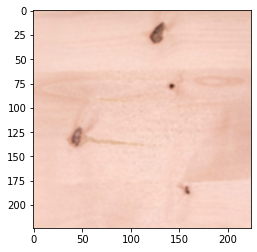

In [23]:
image, original_mask = WoodDataset().__getitem__(5)
plt.imshow(image.permute(1,2,0))


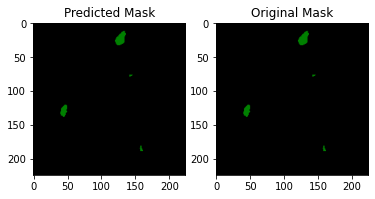

In [24]:
image = image.unsqueeze(0)
predicted_mask = model.predict(image)
fig, axs = plt.subplots(1, 2)
axs[0].imshow(predicted_mask.squeeze(0).permute(1,2,0).detach().numpy())
axs[0].set_title('Predicted Mask')
axs[1].imshow(original_mask.permute(1,2,0))
axs[1].set_title('Original Mask')
plt.show()
# plt.imshow(prediction.squeeze(0).permute(1,2,0).detach().numpy())

## Observation

As we can observe from my above result that my model and hypothesis partially works for this task. We can later write a custom script which finds different colour contours and draw bounding box around those contours thus localizing individual anomaly.

My current model however is overfitted on limited data. For real industrial application task I would try to gather as much as data possible and train a bigger and deeper network.

### How to improve my current approach ?
Nevertheless, here are the following aspects I feel I might have tried to improve my current strategy.

1) Synthetic Data Generation: As my experiment of generating synthetic data failed using poisson blending. However, I feel that using alpha blending my idea would still work. For these we would have to segment anomaly with transparent overlay and later alpha blend those with perfect texture image. By doing so we might be able to generate synthetic data through random permutation.

2) Different model architecture: I really had this one crazy idea to use multi-modal approach to tackle this problem. My idea involved to combine an unsupervised and supervised network together. Unsupervised network would be a pretrained CNN network like ResNet which would provide a coarse heatmap for the anomaly. This heatmap would later be fused at different levels in supervised network to segment and classify those anomalies. The heatmap from the pretrained network would act as inductive bias for localizing the anomalies.

### How to transfer knowledge on different surface ?
1) For knowledge transfer, I would add Batch Norm layers into my network which will help to avoid problem for "internal covariance" shift for new surface and make transfer learning easier.

2) Secondly, I would freeze the weights of well-trained network on wood texture, and later train & finetune final or some intermediate layers(after analyzing).


# Citations
[1] Wada, K. Labelme: Image Polygonal Annotation with Python [Computer software]. https://doi.org/10.5281/zenodo.5711226 <br/>
[2] Patrick Pérez, Michel Gangnet, and Andrew Blake. 2003. Poisson image editing. In ACM SIGGRAPH 2003 Papers (SIGGRAPH '03). Association for Computing Machinery, New York, NY, USA, 313–318. https://doi.org/10.1145/1201775.882269